<a href="https://colab.research.google.com/github/TsukeBarrel/ocr_task/blob/main/ocr_task_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/TsukeBarrel/ocr_task.git

Cloning into 'ocr_task'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 6 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 755.88 KiB | 2.54 MiB/s, done.


In [ ]:
!pip install easyocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 12.3 MB/s eta 0:00:00


                      報 醐   消費税10%   源泉所得税     立替金 前受金     ご請求金額
弁護士法人AZx総合法律事務所  平539,300   平3,930       t  42,812   t  4596,042
AZX国際特許事務所        117,500   11,750   1,786   0001し   t   118,464
計                1556,800  155,680  11,786  13,812   t  1614,506


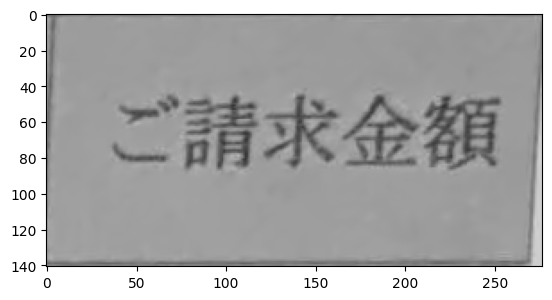

In [14]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import easyocr
import copy
import pandas as pd

get_ipython().run_line_magic('matplotlib', 'inline')

def show_img(img):
    plt.imshow(img)

def show_gray_img(img):
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

def edge_extraction(img):
    threshold1 = 100
    threshold2 = 100
    edges = cv2.Canny(img, threshold1, threshold2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_image = cv2.dilate(edges,kernel,iterations = 1)

    show_gray_img(dilated_image)

    return dilated_image

def ROI_extraction(img):
    y_size, x_size = img.shape
    contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    max_cnt = max(contours, key=lambda x: cv2.contourArea(x))
    rect = cv2.minAreaRect(max_cnt)
    center, size, angle = rect
    width, height = size
    width += 20
    height += 30
    size = (width, height)
    center = tuple(map(int, center))
    size = tuple(map(int, size))
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    M = cv2.getRotationMatrix2D(center, angle, 1)
    rotated_img = cv2.warpAffine(denoised_image, M, (x_size, y_size))
    cropped_img = cv2.getRectSubPix(rotated_img, size, center)

    return cropped_img

def ROI_detection(img):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours = list(filter(lambda x:  50000 > cv2.contourArea(x) > 20000, contours))

    rectangles = []

    for cnt in contours:
      rect = cv2.boundingRect(cnt)
      rectangles.append(rect)

    #y軸方向にソート。pandasを用いてCSV化するため、行ごとにセルをまとめる下準備
    rectangles.sort(reverse=False, key=lambda x:x[1])

    row_0 = copy.deepcopy(rectangles[0:7])
    row_1 = copy.deepcopy(rectangles[7:14])
    row_2 = copy.deepcopy(rectangles[14:21])
    row_3 = copy.deepcopy(rectangles[21:28])

    table_list = [row_0, row_1, row_2, row_3]

    return table_list

def apply_ocr(table_list, img):
    reader = easyocr.Reader(['ja', 'en'])
    tmp_col = []

    for y_idx, col in enumerate(table_list):
      col.sort(reverse=False, key=lambda x:x[0])
      if y_idx == 0:
          for x_idx, tmp in enumerate(col):
              if x_idx == 0:
                  continue
              else:
                  x, y, w, h = tmp
                  roi = img[y:y+h, x:x+w]
                  tmp_res = reader.readtext(roi, detail=0)
                  tmp_res = ''.join(tmp_res)
                  tmp_col.append(tmp_res)
          res_df = pd.DataFrame(columns=[tmp_col])
          tmp_col.clear()

      else:
          for x_idx, tmp in enumerate(col):
              if x_idx == 0:
                  x, y, w, h = tmp
                  roi = img[y:y+h, x:x+w]
                  tmp_res = reader.readtext(roi, detail=0)
                  tmp_res = ''.join(tmp_res)
                  tmp_idx = tmp_res
              else:
                  x, y, w, h = tmp
                  roi = img[y:y+h, x:x+w]
                  tmp_res = reader.readtext(roi, detail=0)
                  tmp_res = ''.join(tmp_res)
                  tmp_col.append(tmp_res)
          res_df.loc[tmp_idx] = tmp_col
          tmp_col.clear()

    print(res_df)

    res_df.to_csv(r'./ocr_task/data/ocr_task_res.csv')

if __name__ == "__main__":

    image = cv2.imread(r"./ocr_task/data/表抽出課題.png")

    if image is None:
        print("image is not correctly loaded")
    else:
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        denoised_image = cv2.fastNlMeansDenoising(image_gray)

        dilated_image = edge_extraction(denoised_image)
        cropped_image = ROI_extraction(dilated_image)
        dilated_cropped_image = edge_extraction(cropped_image)
        table_list = ROI_detection(dilated_cropped_image)
        apply_ocr(table_list, cropped_image)
        print('process finished')